# Setup

In [1]:
import voxlogica
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import os.path

baseimage = './src/test/java/io/github/contractautomata/maze/resources/maze3.png'
datadir = './src/test/java/io/github/contractautomata/maze/resources/twoagentsimages/png'
images = [fname for fname in os.listdir(datadir) if fname.endswith(".png")]
tmpdir = "./tmp"
cache = "./cache.json"

# Result computation and auxiliary function "view"

In [2]:
def run_analysis(specification,image):
    print(f'Analysing {image}... ', end='')
    res = voxlogica.run_voxlogica(specification(image))
    print('done')
    return res


def compute(specification,start=0,end=len(images)-1):
    voxlogica_output = [
        {"filename": image, "output": run_analysis(specification,image)} for image in images[start:end+1]]

    # %%
    return voxlogica.simplify_results(voxlogica_output)
# %%


def view(result,rows = 5,cols = 5,sizex = 20,sizey = 20):
    fname = result["filename"]
    plt.figure(figsize=(sizex,sizey))
    img = mpimg.imread(f'{datadir}/{fname}')
    ax=plt.subplot(rows,cols,1)
    ax.set_title("model")
    plt.imshow(img)
    i=2
    toprint = {}
    for (key,value) in result["results"].items():
        if isinstance(value,(int,float)):
            toprint[key] = value
            #toprint.append(f'{key}: {value}')            
        else:
            fmla = f'{key.removeprefix(fname+"_")}'
            img = mpimg.imread(f'{tmpdir}/{value["filename"]}')            
            ax = plt.subplot(rows,cols,i)    # the number of images in the grid is 5*5 (25)    
            ax.set_title(fmla)
            plt.imshow(img,cmap="Greys_r")
            i = i+1            
    plt.show()     
    print(toprint)           

# Specification and analysis

In [3]:
def vlsave(image,var):
    return f'save "{tmpdir}/{image}_{var}.png" {var}'

def vlprint(var):
    return f'print "{var}" {var}'

def specification(image):
    return f'''

load base ="{baseimage}"

load img = "{datadir}/{image}"
let r = red(img)
let g = green(img)
let b = blue(img)
let rb = red(base)
let gb = green(base)
let bb = blue(base)

let exists(p) = volume(p) .>. 0
let forall(p) = volume(p) .=. volume(tt)
let forallin(x,p) = forall( (!x) | p)

let door = (r =. 0) & (b =. 255) & (g =. 0)
let floorNoDoor = (rb =. 255) & (bb =. 255) & (gb =. 255)
let floor = floorNoDoor & (!door)
let wall = !floor


let mrRed = (r =. 255) & (b =. 0) & (g =. 0)
let mrGreen = (r =. 0) & (b =. 0) & (g =. 255)

let mrX = mrRed | mrGreen

let wrong = exists(mrX & wall)
let exit = (x =. 9) & (y >. 2) & (y <. 9)
let pathToExit = (floor ~> exit)
let canExit(mr) = forallin(mr,pathToExit)
let sameRoom = forallin(mrGreen,(mrGreen|floor) ~> mrRed)

let greenEscapes = (!.wrong) .&. canExit(mrGreen) .&. (!.(canExit(mrRed)))
let nearby = exists(mrRed & (N N mrGreen))

{vlprint("canExit(mrGreen)")}
{vlprint("wrong")}
{vlprint("sameRoom")}
{vlprint("greenEscapes")}
{vlprint("nearby")}
{vlsave(image,"door")}
{vlsave(image,"exit")}
{vlsave(image,"mrRed")}
{vlsave(image,"mrGreen")}
{vlsave(image,"pathToExit")}


'''
items = []
if (os.path.exists(cache)):    
    with open(cache) as f:
        items = json.load(f)
else:
    items = compute(specification)
    with open(cache, 'w') as f:
        json.dump(items, f)    


In [6]:
ok = [item for item in items if not item["results"]["wrong"] ]

In [7]:
len(ok)

3362

In [9]:
escape = [item for item in items if item["results"]["greenEscapes"] ]

In [10]:
len(escape)

378

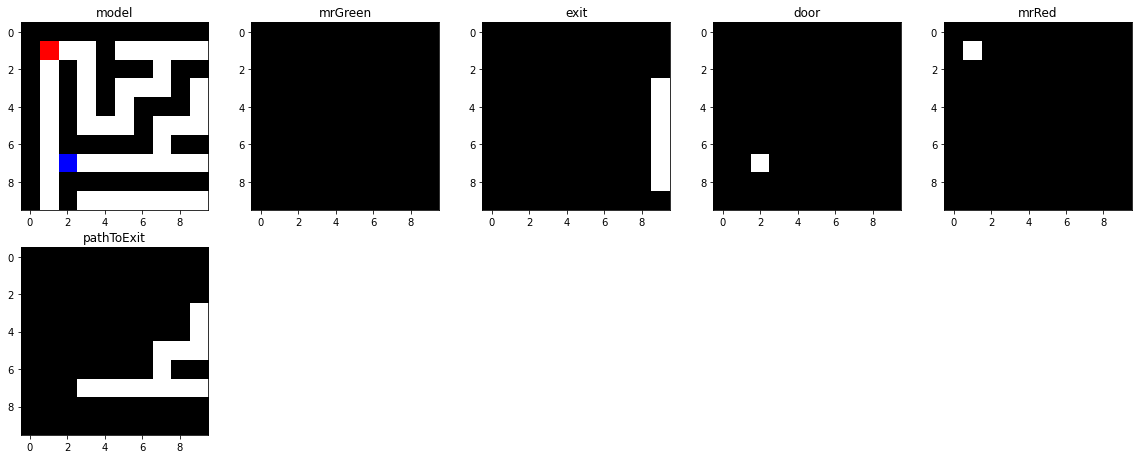

{'wrong': False, 'nearby': False, 'sameRoom': True, 'canExit(mrGreen)': True, 'greenEscapes': True}


In [11]:
view(escape[0])